In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense, Dropout

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('Preprocess_Reviews.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment,neg,neu,pos,compound
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,feel lucky found used phone u used hard phone ...,1.0,positive,0.100,0.592,0.308,0.8966
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,positive,0.155,0.445,0.400,0.8548
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,pleased,0.0,positive,0.000,0.000,1.000,0.4404
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,work good go slow sometimes good phone love,0.0,positive,0.000,0.333,0.667,0.8750
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,great phone replace lost phone thing volume bu...,0.0,positive,0.103,0.714,0.183,0.4215


In [3]:
#Drop unnecessary columns:
df = df.drop(['Product Name', 'Price', 'Review Votes', 'Brand Name'], axis=1)
df.dropna(inplace=True)

In [4]:
df_Positive = df[df['sentiment'] == 'positive'][0:20000]
df_Neutral = df[df['sentiment'] == 'neutral']
df_Negative = df[df['sentiment'] == 'negative']

In [5]:
df_Neutral_over = df_Neutral.sample(20000, replace=True)
df_Negative_over = df_Negative.sample(20000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [6]:
df

,Rating,Reviews,sentiment,neg,neu,pos,compound
0,5,feel lucky found used phone u used hard phone ...,positive,0.100,0.592,0.308,0.8966
1,4,nice phone nice grade pantach revue clean set ...,positive,0.155,0.445,0.400,0.8548
2,5,pleased,positive,0.000,0.000,1.000,0.4404
3,4,work good go slow sometimes good phone love,positive,0.000,0.333,0.667,0.8750
4,4,great phone replace lost phone thing volume bu...,positive,0.103,0.714,0.183,0.4215
...,...,...,...,...,...,...,...
108139,1,english spanish realy,negative,0.000,1.000,0.000,0.0000
274620,1,purchased phone husband even week charging num...,negative,0.128,0.811,0.061,-0.3753
110670,1,phone worth money lack lte channel reception s...,negative,0.289,0.444,0.267,-0.1027
182157,1,personally like nokia lot people told nicether...,negative,0.144,0.671,0.185,0.1835


In [7]:
# Tokenization and padding
max_length = 100  # Adjust according to your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Reviews'])
X = tokenizer.texts_to_sequences(df['Reviews'])
X = pad_sequences(X, maxlen=max_length)

In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])


In [9]:
# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)


In [10]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define model parameters
embedding_dim = 100  # Dimension of word embeddings
vocab_size = len(tokenizer.word_index) + 1


In [12]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))  # Dropout layer to prevent overfitting
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for multi-class classification

C:\Users\MK Jutt\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
epochs = 10
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 215s 520ms/step - accuracy: 0.5620 - loss: 0.8530 - val_accuracy: 0.7707 - val_loss: 0.5543
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 201s 536ms/step - accuracy: 0.8002 - loss: 0.5158 - val_accuracy: 0.8061 - val_loss: 0.4921
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 238s 635ms/step - accuracy: 0.8486 - loss: 0.4106 - val_accuracy: 0.8180 - val_loss: 0.4731
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 208s 554ms/step - accuracy: 0.8738 - loss: 0.3499 - val_accuracy: 0.8288 - val_loss: 0.4720
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 585ms/step - accuracy: 0.8902 - loss: 0.3075 - val_accuracy: 0.8372 - val_loss: 0.4489
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 216s 575ms/step - accuracy: 0.9031 - loss: 0.2743 - val_accuracy: 0.8431 - val_loss: 0.4816
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 538ms/step - accuracy: 0.9101 - loss: 0.2507 - val_accuracy: 0.8463 - val_loss: 0.4780
Epoch 7: early stopping


In [16]:
# Evaluate model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8483 - loss: 0.4688
Validation Loss: 0.4780
Validation Accuracy: 0.8463


In [17]:

# Plot training history
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

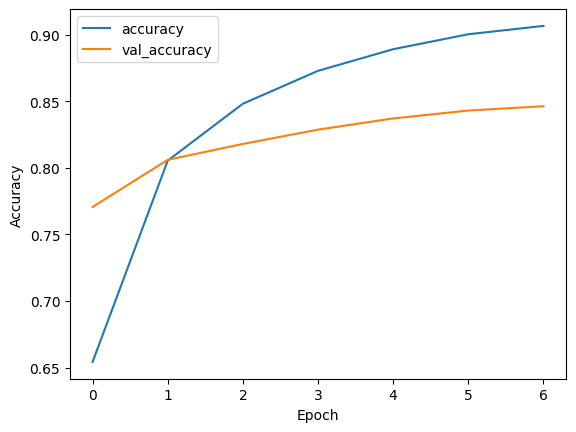

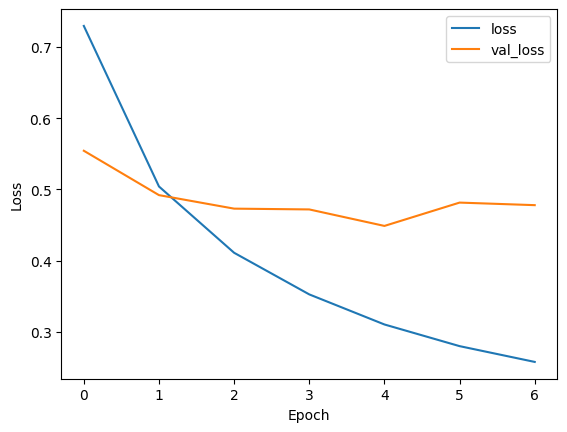

In [18]:
# Plot accuracy and loss
plot_history(history)

In [19]:
import joblib
# Save the best model to a file
joblib_file = "LSTM_model.joblib"
joblib.dump(model, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to LSTM_model.joblib


In [20]:
# Load the model from the file
loaded_model = joblib.load("LSTM_model.joblib")
print("Model loaded successfully")

Model loaded successfully


In [21]:
# Example of making predictions
new_reviews = ["My phone not working welll", "I appreciate that company to providing good product."]
sequences = tokenizer.texts_to_sequences(new_reviews)
padded_sequences = pad_sequences(sequences, maxlen=max_length)
predictions = loaded_model.predict(padded_sequences)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


In [22]:
# Decode predictions
predicted_labels = label_encoder.inverse_transform([np.argmax(pred) for pred in predictions])

In [23]:
for review, predicted_label, prediction in zip(new_reviews, predicted_labels, predictions):
    sentiment = predicted_label
    confidence = prediction[np.argmax(prediction)]
    print(f'Review: {review} | Predicted Sentiment: {sentiment} | Confidence: {confidence:.4f}')

Review: My phone not working welll | Predicted Sentiment: negative | Confidence: 0.6751
Review: I appreciate that company to providing good product. | Predicted Sentiment: positive | Confidence: 0.9456
